<a href="https://colab.research.google.com/github/TheNoboby12/SRIP-Task-notebooks/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement two hidden layers neural network classifier from scratch in JAX 
[20 Marks] <br>
<br>
● Two hidden layers here means (input - hidden1 - hidden2 - output).

● You must not use flax, optax, or any other library for this task.

● Use MNIST dataset with 80:20 train:test split.

● Manually optimize the number of neurons in hidden layers.

● Use gradient descent from scratch to optimize your network. You should use the Pytree concept of JAX to do this elegantly.

● Plot loss v/s iterations curve with matplotlib.

● Evaluate the model on test data with various classification metrics and briefly discuss their implications.


# **Solution**
 This notebook contain implementation

Importing all Libraries needed 
* sklearn
* jax




In [40]:
import jax.numpy as jnp
# special transform function
from jax import grad, jit, vmap, value_and_grad,soft_pmap
from sklearn.model_selection import train_test_split

# Dataset
I have load MNIST dataset from mnist.npz file. 
then made a fuction to extract it. 
it give result 

In [41]:


def get_mnist():
    with jnp.load(f'/content/drive/MyDrive/mnist.npz') as f:
        images, labels = f["x_train"], f["y_train"]
    images = images.astype("float32").reshape([-1,28,28,1]) / 255
    images = jnp.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))
    labels = jnp.eye(10)[labels]
    return images, labels

We created a MLP class which stand for MultiLayer Perceptron. It has initial variablle assigned. then it has following fuction for this tasks:
1.   forwad Propagation
2.   backward Propagation
3.   training part
4. gradient descent
5. sigmoid function
6. sigmoid derivatives
7. Mean Square error fuction


In [42]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
import jax

class MLP(object):
    """A Multilayer Perceptron class.
    """

    def __init__(self, num_inputs, hidden_layers, num_outputs):
        """Constructor for the MLP. Takes the number of inputs,
            a variable number of hidden layers, and number of outputs
        Args:
            num_inputs (int): Number of inputs
            hidden_layers (list): A list of ints for the hidden layers
            num_outputs (int): Number of outputs
        """

        self.num_inputs = num_inputs
        self.hidden_layers = hidden_layers
        self.num_outputs = num_outputs

        key = jax.random.PRNGKey(0)

        # create a generic representation of the layers
        layers = [num_inputs] + hidden_layers + [num_outputs]

        # create random connection weights for the layers
        weights = []
        for i in range(len(layers) - 1):
            w = jax.random.uniform(key,shape=(layers[i], layers[i + 1]))
            weights.append(w)
        self.weights = weights

        # save derivatives per layer
        derivatives = []
        for i in range(len(layers) - 1):
            d = jnp.zeros((layers[i], layers[i + 1]))
            derivatives.append(d)
        self.derivatives = derivatives

        # save activations per layer
        activations = []
        for i in range(len(layers)):
            a = jnp.zeros(layers[i])
            activations.append(a)
        self.activations = activations


    def forward_propagate(self, inputs):
        """Computes forward propagation of the network based on input signals.
        Args:
            inputs (ndarray): Input signals
        Returns:
            activations (ndarray): Output values
        """

        # the input layer activation is just the input itself
        activations = inputs

        # save the activations for backpropogation
        self.activations[0] = activations

        # iterate through the network layers
        for i, w in enumerate(self.weights):
            # calculate matrix multiplication between previous activation and weight matrix
            net_inputs = jnp.dot(activations, w)

            # apply sigmoid activation function
            activations = self._sigmoid(net_inputs)

            # save the activations for backpropogation
            self.activations[i + 1] = activations

        # return output layer activation
        return activations


    def back_propagate(self, error):
        """Backpropogates an error signal.
        Args:
            error (ndarray): The error to backprop.
        Returns:
            error (ndarray): The final error of the input
        """

        # iterate backwards through the network layers
        for i in reversed(range(len(self.derivatives))):

            # get activation for previous layer
            activations = self.activations[i+1]

            # apply sigmoid derivative function
            delta = error * self._sigmoid_derivative(activations)

            # reshape delta as to have it as a 2d array
            delta_re = delta.reshape(delta.shape[0], -1).T

            # get activations for current layer
            current_activations = self.activations[i]

            # reshape activations as to have them as a 2d column matrix
            current_activations = current_activations.reshape(current_activations.shape[0],-1)

            # save derivative after applying matrix multiplication
            self.derivatives[i] = jnp.dot(current_activations, delta_re)

            # backpropogate the next error
            error = jnp.dot(delta, self.weights[i].T)


    def train(self, inputs, targets, epochs, learning_rate):
        """Trains model running forward prop and backprop
        Args:
            inputs (ndarray): X
            targets (ndarray): Y
            epochs (int): Num. epochs we want to train the network for
            learning_rate (float): Step to apply to gradient descent
        """
        x,y=[],[]
        # now enter the training loop
        for i in range(epochs):
            sum_errors = 0
            # x.append(sum_errors / len(items))
            #     y.append(i+1)
            # iterate through all the training data
            for j, input in enumerate(inputs):
                target = targets[j]

                # activate the network!
                output = self.forward_propagate(input)

                error = target - output

                self.back_propagate(error)

                # now perform gradient descent on the derivatives
                # (this will update the weights
                self.gradient_descent(learning_rate)
                # Get the sampled loss

                # loss = self._mse(target,output)
                # x.append(self._mse(target,output))
                # keep track of the MSE for reporting later
                sum_errors += self._mse(target, output)
                x.append(sum_errors)
                y.append(i+1)
               

            plt.plot(x,y)
            plt.xlabel("Loss")
            plt.ylabel("Iterartion/Epochs")
            # Epoch complete, report the training error
            print("Error: {} at epoch {}".format(sum_errors / len(items), i+1))

        
      
        print("Training complete!")
        print("=====")
        

    def gradient_descent(self, learningRate):
        """Learns by descending the gradient
        Args:
            learningRate (float): How fast to learn.
        """
        # update the weights by stepping down the gradient
        for i in range(len(self.weights)):
            weights = self.weights[i]
            # weights += jax.tree_multimap(self.derivatives[i] * learningRate)
            # We perform one gradient update
            weights = jax.tree_multimap(lambda old, grad: old - learningRate * grad,weights, self.derivatives[i])
          


    def _sigmoid(self, x):
        """Sigmoid activation function
        Args:
            x (float): Value to be processed
        Returns:
            y (float): Output
        """

        y = 1.0 / (1 + jnp.exp(-x))
        return y


    def _sigmoid_derivative(self, x):
        """Sigmoid derivative function
        Args:
            x (float): Value to be processed
        Returns:
            y (float): Output
        """
        return x * (1.0 - x)


    def _mse(self, target, output):
        """Mean Squared Error loss function
        Args:
            target (ndarray): The ground trut
            output (ndarray): The predicted values
        Returns:
            (float): Output
        """
        return jnp.average((target - output) ** 2)

this the Evaluation part of code:-<br>
We first traain our model and then test it .<br>
data is splited using train_test_split in 80:20 ratio.
we call our MLP class assigned values as
MLP(number of inputs, number of hidden layer,number of output)

Error: 0.8998313546180725 at epoch 1
Error: 0.8998313546180725 at epoch 2
Error: 0.8998313546180725 at epoch 3
Error: 0.8998313546180725 at epoch 4
Error: 0.8998313546180725 at epoch 5
Error: 0.8998313546180725 at epoch 6
Error: 0.8998313546180725 at epoch 7
Error: 0.8998313546180725 at epoch 8
Error: 0.8998313546180725 at epoch 9
Error: 0.8998313546180725 at epoch 10
Training complete!
=====

Output =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


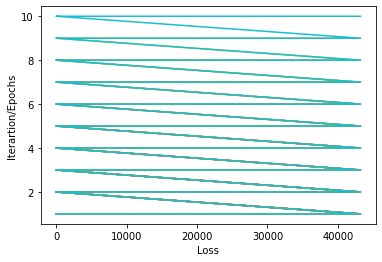

In [46]:
imgs,labels = get_mnist()
X_train, X_test, y_train, y_test = train_test_split(imgs,labels, test_size=0.2)
# TF_CPP_MIN_LOG_LEVEL=0
# mlp
if __name__=="__main__":

    # create a dataset to train a network for the sum operation
    items = X_train
    targets = y_train
    
    # create a Multilayer Perceptron with one hidden layer
    mlp = MLP(784, [128,64], 10)

    # train network
    learning_rate=0.0002
    epochs = 10
    mlp.train(items, targets, epochs, learning_rate)

    # # create dummy data
    input = X_test 
    target = y_test

    # get a prediction
    output = mlp.forward_propagate(input)
    print()
    print("Output =  {}".format( output[0]))